# Sequence to Sequence em PyTorch

Este tutorial é uma versão modificada de https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb

Neste tutorial iremos ensinar como treinar uma rede neural para traduzir sentenças do portugues para o inglês.

Isto é possível graças a simples mas poderosa idéia da [rede sequence to sequence](http://arxiv.org/abs/1409.3215), na qual duas redes neurais recorrentes transformam uma sequência de símbolos em outra sequência. A rede codificadora condensa uma sequência de entrada em um vetor e a rede decodificadora converte esse vetor em uma nova sequência.

Para melhorar este modelo iremos usar o [mecanismo de atenção](https://arxiv.org/abs/1409.0473), o qual faz com que o decodificador aprenda a se atentar a partes específicas da sequência de entrada.

# O modelo de Sequence to Sequence

A [rede Sequence to Sequence](http://arxiv.org/abs/1409.3215), ou rede seq2seq, ou [rede Codificadora-Decodificadora](https://arxiv.org/pdf/1406.1078v3.pdf), é um modelo que possui duas redes RNNs chamadas de  **codificadora** e **decodificadora**. O codificador lê a sequência de entrada um item por vez e retorna um vetor a cada passo. A saída final do codificador é um vetor de **contexto**, representado na figura abaixo por $h_5$. O decodificador usa esse vetor de contexto para produzir uma sequência de simbolos, um de cada vez.

<img src="../figures/NMT-Simples.png",width=700>

Quando trabalhamos com tradução automática, é comum não termos uma relação de um para um entre os textos de entrada e os de saída. Por exemplo, dada a sentença "Eu não gosto daquele vestido preto" e sua tradução "I don't like that black dress", muitas das palavras tem uma tradução direta, como "gosto" e "like". Entretanto, diferenças gramaticais podem acaretar em diferentes ordenações das palavras, como por exemplo "vestido preto" e "black dress". Há também diferenças na construção da negação 'do not' e 'não', que faz com que as sentenças tenham diferentes tamanhos.

Com o modelo seq2seq, o codificador converte a entrada para um vetor de tamanho fixo, não importando seu tamanho original. E o decodificador produz sequências de tamanho não fixo, mesmo usando um vetor de tamanho fixo como entrada.

Esta idéia pode ser extendida para além de sequências. Geração automática de legenda de imagens é uma delas (https://arxiv.org/abs/1411.4555), onde a entrada é uma imagem e a saída é um texto descrevendo a imagem. O inverso também é possivel, onde a entrada é a descrição textual de um objeto e a saída é a imagem deste objeto (https://arxiv.org/abs/1511.02793). Estes modelos podem ser mais genericamente chamados de redes "codificadoras decodificadoras".

## O Mecanismo de Atenção

O vetor de tamanho fixo carrega o ônus de representar todo a "semântica" da sequência de entrada, não importa o quão longa ela seja. Com todas as variações da linguagem, este é um problema bem difícil. Imagine duas sentenças quase idênticas, com 20 palavras cada, diferindo em apenas uma palavra. O codificador e o decodificador precisam ser poderosos o suficiente para capturar essa pequena mudança na representação.

O **mecanismo de atenção** introduzido por [Bahdanau et al.](https://arxiv.org/abs/1409.0473) tenta resolver esse problema através de um mecanismo que permite que o decodificador "preste atenção" em partes da sequência de entrada ao invés de depender de uma vetor de tamanho fixo. A cada passo, o decodificador pode considerar partes diferentes da sequência de entrada.

A figura abaixo mostra uma rede seq2seq com o mecanismo de atenção. O módulo de atenção (Att) tem como entrada todos os vetores da sequência de entrada ($h_1, ..., h_5$), e a saída é um vetor de tamanho fixo ($h'_2$) que é a soma ponderada dos vetores da sequência de entrada. Os pesos dessa soma ponderada são calculados por uma rede neural simples que tem como entrada o vetor de estado obtido no passo anterior ($g_1$) e os vetores da sequência de entrada ($h_1, ..., h_5$). Para que a soma dos pesos fique entre 0 e 1, a função de softmax é usada.
O novo vetor de atenção ($g_2$) é então usado para gerar a próxima saída.

<img src="../figures/NMT-Attention.png",width=700>

# Requisitos

Você precisará do [PyTorch](http://pytorch.org/) para treinar os modelos e do [matplotlib](https://matplotlib.org/) para visualizar o treinamento e os pesos do mecanismo de atenção.

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Abaixo iremos definir uma constante que diz se iremos usar uma GPU ou CPU. **Se você não possuir uma GPU, deixe esta variável como `False`**. Mais tarde quando criarmos tensores, esta variável será usada para decidir se os executaremos na CPU ou na GPU.

In [2]:
USE_CUDA = False

# Carregando o Dataset

Os dados para esse tutorial vem do site http://www.manythings.org/anki/, o qual contém milhares de pares de sentenças em diversos idiomas que foram originalmente extraídos de http://tatoeba.org/. Neste tutorial iremos usar apenas os pares português-inglês, então basta fazer download do arquivo http://www.manythings.org/anki/por-eng.zip, extraí-lo na mesma pasta deste notebook e renomeá-lo para `eng-por.txt`. Este arquivo contém mais de 100.000 pares de sentenças separadas por tab:

```
I'm cold.	Estou com frio.
```

Nós iremos reprensentar cada palavra como um vetor one-hot, que é um vetor do tamanho do vocabulário usado (ex: 300.000 palavras únicas) onde todos os elementos são zero com exceção de um único elemento, que corresponde ao índice da palavra. Como este vetor pode ser muito grande, iremos limitar nosso vocabulário para apenas algumas milhares de palavras por língua.

### Indexando palavras

Nós precisaremos de um índice único por palavra para usá-lo como entrada e sáida da rede. Para isso, utilizaremos uma classe que chamaremos de 'Lang', que possui dois dicionários: palavra &rarr; índice (`word2index`) e índice &rarr; palavra (`index2word`). Esta classe também armazena o número de occorências de cada palavra (`word2count`), que será usada mais tarde para lidarmos com palavras raras.

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Conta Start-of-Sequence (SOS) e End-of-Sequence (EOS)
      
    def index_words(self, sentence):
        '''
        Adiciona o número de ocorrências das palavras de uma sentença no contador geral. 
        '''
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            # Se a palavra não estiver no dicionário, crie uma entrada para ela, com contagem = 1.
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            # Caso já exista no dicionário, apenas incremente seu número de ocorrências.
            self.word2count[word] += 1

### Lendo e decodificando arquivos

Os arquivos estão em formato unicode e para simplificar iremos convertê-los para ASCII, caixa baixa, e remover a maioria da pontuação.

In [4]:
# Converte uma string Unicode para ASCII. Extraído de http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Caixa baixa, remove espaços antes e depois, e remove caracteres que não são letras
def normalize_string(s):
    #s = s.decode('ascii', 'ignore').lower().strip()
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

O arquivo é lido linha por linha, e cada linha é dividida em um par de sentenças. Os arquivos são sempre do tipo  Inglês &rarr; Outra Língua, então se quisermos traduzir da outra língua para o inglês basta passarmos o argumento reverse=True para a função abaixo.

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Lendo Linhas...")

    # Lê o arquivo e o divide em linhas
    lines = open('/data/datasets/seq2seq-translation/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Divide cada linha em um par de sentenças e normaliza-as.
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Inverte os pares
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### Removendo sequências longas

Como temos muitos exemplos (mais de 100.000) e queremos que o treinamento seja rápido, iremos remover todas as sentenças com mais de 10 palavras do dataset. Também removeremos todas as sentenças que não começam com termos simples, como "I am" and "He is", pois isso acelera o treino ainda mais.

In [6]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(good_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

Em suma, o processo de preparação dos dados é:
* Ler o arquivo texto e separá-lo em linhas e depois dividir as linhas em pares.
* Normalizar o texto, filtrar por comprimento e conteúdo.
* Converter os pares de sentenças em listas de palavras.

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Lendo par de sentenças %s" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Removendo espaços do par de sentenças %s" % len(pairs))
    
    print("Indexando palavras...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'por', True)

# Imprime um par exemplo
print(random.choice(pairs))

Lendo Linhas...
Lendo par de sentenças 110158
Removendo espaços do par de sentenças 1773
Indexando palavras...
['ele e diplomata na embaixada americana .', 'he is a diplomat at the american embassy .']


In [8]:
# Retorna uma lista de índices, um para cada palavra na sentença.
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

## Convertendo o dataset de treino em Tensores

Para treinar uma rede neural precisamos converter as sentenças (strings) em algo que a rede entenda (tensores). Cada sentença será dividida em palavras. Cada palavra será convertida para um índice (que é nada mais que um número inteiro) e isso que é feito pela classe "Lang", como explicado anteriormente. Após converter todas as palavras em índices, um símbolo chamado de EOS (End-of-Sequence, fim da sequência) é adicionado ao fim da sequência. Este símbolo é a forma de indicarmos para a rede neural que a sequência terminou.

![](https://i.imgur.com/LzocpGH.png)

Um Tensor é um array númerico multi-dimensional e que possui um tipo, por exemplo, Float ou Long. Iremos usar tensores do tipo Long para representar os índices do array.

As redes neurais em pytorch tem como entrada objetos do tipo Variable, que são que tensores que armazenam o  estado do grafo. Isso torna possível o cálculo automático dos gradientes.

# Construindo os modelos

## O Codificador

O codificador de uma rede seq2seq é uma RNN que produz um vetor saída e um vetor de estado para cada palavra da sequência de entrada.

<img src="../figures/encoder-network.png" />

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Nota: está função é executado de uma só vez em toda a sequência de entrada.
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Decodificador com Mecanismo de Atenção

### Interpretando o modelo de Bahdanau et al.

O mecanismo de atenção (https://arxiv.org/abs/1409.0473) é descrito a seguir pelas equações abaixo.

Cada saída do decodificador é condicionada pelas saídas anteriores e alguns $\mathbf x$, onde $\mathbf x$ consiste nos vetores de estado atuais (os quais codificam as saídas anteriores) e o "contexto" de atenção, o qual é calculado abaixo. A função $g$ é uma camada fully-connected com ativação não-linear que tem como entrada os vetores $y_{i-1}$, $s_i$, e $c_i$ concatenados.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

O vetor de estado atual $s_i$ é calculado por uma RNN $f$ usando o vetor de estado anterior $s_{i-1}$, a última saída do decodificador $y_{i-1}$, e o vetor de contexto $c_i$.

No código, a RNN será uma camada do tipo `nn.GRU`, o vetor de estado $s_i$ será chamado de `hidden`, a sáida $y_i$ será chamada `output`, e o contexto $c_i$ será chamado `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

O vetor de contexto $c_i$ é a soma ponderada de todas as saídas do codificador, onde cada peso $a_{ij}$ é a quantidade de atenção "attention" que é prestada ao vetor $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... onde cada peso $a_{ij}$ é a "pontuação" $e_{ij}$ normalizada ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... onde cada pontuação é calculada como usando uma função $a$ (como uma outra camada linear) que tem como entrada o último vetor de estado $s_{i-1}$ e a saída do codificador $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Implementando o modelo de Bahdanau et al.

Em suma, nosso decodificador consiste em quatro módulos principais: - uma camada de embedding que converte uma palavra (string) em um vetor; uma camada que calcula a pontuação para cada saída do codificador; uma camada RNN; e uma camada de saída.

As entradas do decodificador são o último vetor de estado da RNN $s_{i-1}$, última saida do decodificador $y_{i-1}$, e todas as entradas do codificador $h_*$.

* Camada embedding com entradas $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* Camada de atenção $a$ com entradas $(s_{i-1}, h_j)$ e saídas $e_{ij}$, normalizadas de maneira a criar $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* Vetor de contexto $c_i$, que é a média ponderada das saídas do codificador de acordo com os pesos atribuídos pelo mecanismo de atenção.
    * `context = sum(attn_weights * encoder_outputs)`
* Camada(s) RNN $f$ com entradas $(s_{i-1}, y_{i-1}, c_i)$ e vetores de estados, resultantes em $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* Camada de saída $g$ com entradas $(y_{i-1}, s_i, c_i)$, e saída $y_i$
    * `output = out(embedded, rnn_output, context)`

In [10]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Define os parâmetros
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define as camadas
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note que esta função roda o decodificador por apenas um passo mas usa todas as saídas do codificador.
        
        # Converte a última palavra escolhida pelo decodificador para um vetor (embedding)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calcula os pesos de atenção e aplica-os as saídas do codificador.
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Concatena o vetor da palavra de entrada com o vetor de contexto de atenção, e envia-os para a RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Camada de saída final
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Retorna saída final (palavra escolhida), vetor de estado, e pesos do mecanismo de atenção (para visualização)
        return output, hidden, attn_weights

### Interpretando os modelos de Luong et al.

O artigo [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) por Luong et al. descreve outros modelos de atenção que possuem melhores resultados e algumas simplicações. Eles descrevem alguns modelos de "atenção global", que diferem do original na forma como as pontuações de atenção são calculadas.

De maneira geral, o cálculo dos pesos de atenção depende do vetor de estado produzido pelo decodificador e de todos os vetores de estado produzidos pelo codificador. Uma normalização para que a soma dos pesos seja 1 é feita em seguida.

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

A função "score" que compara os dois estados pode ser: *dot*, o produto escalar entre esses dois vetores (*dot*); *general*, um produto escalar entre o vetor de estado do decodificador e uma transformação linear do vetor de estado do codificador; ou *concat*, um produto escalar entre um novo parâmetro $v_a$ e uma transformação linear dos vetores de estados concatenados.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

A definição dessas funções nos dá a oportunidade de criar módulos de atenção específicos. A entrada para este módulo é sempre o vetor de estado do decoficador e as saídas do codificador.

In [11]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Cria variável para amarzenar os pesos calculados pelo mecanismo de atenção.
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calcula os pesos para cada saída do codificador.
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden.squeeze(0), encoder_outputs[i].squeeze(0))

        # Normaliza os pesos para ficarem entre 0 e 1, redimensiona para 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

Agora podemos criar um decodificador que usa esse módulo de atenção após a chamada da RNN. Este módulo calculará os pesos e fará a soma ponderada das saídas do codificador usando esses pesos para obter o vetor de contexto.

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Mantém os parâmetros para referências futuras.
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define as camadas.
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Escolhe o modelo de atenção
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Nota: rodamos essa função a cada passo
        
        # Transforma palavra atual em vetor (embedding)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combina o vetor da palavra com o último vetor de contexto e roda a RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calcula os pesos do mecanismo de atenção usando o vetor de estado atual e todas as saídas do codificador
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        # Aplica os pesos nos vetores do codificador
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Camada final (predição da próxima palavra) usando o vetor de estado da RNN e o vetor de contexto.
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Retorna a palavra selecionada, vetor de estado, e pesos do mecanismo de atenção (para visualização)
        return output, context, hidden, attn_weights

### Testando os modelos

Para garantir que o codificador e o decodificador estejam funcionando, iremos fazer um teste rápido com entradas artificiais:

In [13]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear (20 -> 10)
  (attn): Attn (
    (attn): Linear (10 -> 10)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


# Treinamento

## Definindo uma iteração

Para treinar, primeiramente entramos com a sentença original no codificador, palavra por palavra, e mantemos cada saída e o último vetor de estado. Em seguida, o último vetor de estado do codificador é usado como o primeiro vetor de estado do decodificador e o símbolo `<SOS>` (Start Of Sequence, início da sequência) é dado como primeira palavra de entrada. A partir daí, iremos iterar o decodificador para prever as próximas palavras.

### Aprendizado Supervisionado e Scheduled Sampling

No aprendizado supervisionado (também chamado de "Teacher Forcing" ou maximum likelihood sampling) uma saída "real" é usada como sinal de treino para o modelo. Uma alternativa seria usar a própria predição do decodificador como próxima entrada.

As saídas das redes treinadas com supervisão frequentemente geram traduções que são corretas gramaticalmente mas erradas do ponto de vista semântico. É como se a rede tivesse aprendido a prestar atenção nas instruções do professor mas não consegue criar frases próprias.

Uma solução para este problema é método de [Scheduled Sampling](https://arxiv.org/abs/1506.03099), que alterna entre valores preditos pela rede e os sinais de supervisão durante o treinamento. Durante o treinameto, iremos escolher aleatoriamente quando usar um sinal supervisionado e quando seguir a própria predição da rede.

In [14]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zerar os gradientes
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    # Obter o tamanho das sentenças de entrada e reais
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Codificar
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Preparar entradas para o decodificador
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Escolher se iremos usar sinal supervisionado (teacher forcing)
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: use a palavra "real/verdadeira" como próxima entrada.
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Sem teacher forcing: use a última predição da rede como próxima entrada.
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Use a palavra com maior probabilidade como saída
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Palavra escolhida será a próxima entrada
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Pare caso o símbolo de EOS (End-Of-Sequence) foi escolhido.
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

Algumas funções auxiliares para imprimir os tempos de processamento e progresso.

In [15]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / max(0.0001,percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Treinando

Finalmente, podemos iniciar o treino.

In [16]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Inicializa os modelos
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move os modelos para a GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Inicializa os otimizadores e função de custo (aqui chamada de criterion)
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Configura as variáveis de treino e monitoramento:

In [17]:
n_epochs = 50000
plot_every = 200
print_every = 1000

# mantenha o tempo gasto e custo médio por iteração
start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

Para treinar, podemos chamar a função "train" várias vezes, que imprimirá um resumo cada vez que for interrompida.

In [18]:
# Começa!
try:
    for epoch in range(1, n_epochs + 1):

        # Amostra dados de treino para esta época.
        training_pair = variables_from_pair(random.choice(pairs))
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        # Roda a função de treino.
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        print_loss_total += loss
        plot_loss_total += loss

        if epoch == 0: continue

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
            print(print_summary)

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
except KeyboardInterrupt:
    pass

## Visualizando as curvas de custo

Usamos o matplotlib e o array `plot_losses`, que foi criado enquanto treinávamos.

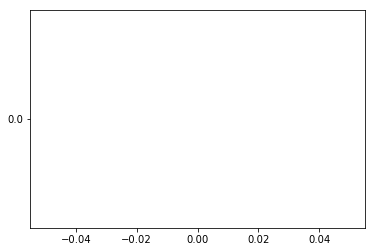

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # coloque ticks em intervalos regulares
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Avaliando a rede

O procedimento para avaliação é quase o mesmo que o de treinamento, mas agora não existem senteças "reais" como referência. Neste caso, as predições do decodificador são sempre usadas como a próxima entrada. Ou seja, toda vez que o decodificador prediz uma palavra, essa palavra será adicionada na string de saída. Se o decodificador predizer o símbolo EOS, a execução será interrompida. Iremos também armazenar os pesos de atenção para visualização.

In [21]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Codificação
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Cria os vetores iniciais para o decodificador.
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Decodificação
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Escolha a palavra com maior probabilidade
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # A próxima entrada será a palavra escolhida como saída deste passo.
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

Podemos avaliar sentenças escolhidas aleatóriamente do dataset de treino para fazermos uma análise qualitativa:

In [22]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [23]:
evaluate_randomly()

> ela e bela .
= she is beautiful .
< is is is . <EOS>



# Visualizando o mecanismo de atenção

Uma propriedade útil do mecanismo de atenção são as saídas interpretáveis. Os pesos desse mecanismo podem ser usados para availar onde a rede prestou mais atenção em cada passo.

Rode `plt.matshow(attentions)` para ver a saída mostrada como uma matriz, onde as colunas são passos de entrada e as linhas são os passos de saída:

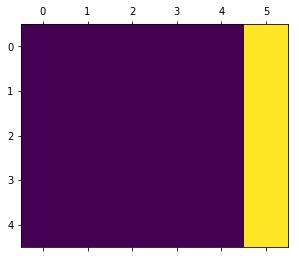

In [24]:
output_words, attentions = evaluate("eu estou com frio .")
plt.matshow(attentions.numpy())

Para uma melhor visualização, adicionamos títulos nos eixos e legenda:

In [25]:
def show_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Configura eixos
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Exibe legenda
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = ela tem cinco anos a menos que eu .
output = is is is . <EOS>


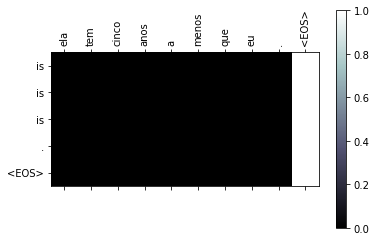

In [26]:
evaluate_and_show_attention("ela tem cinco anos a menos que eu .")

input = o carro era muito grande .
output = is is is . <EOS>


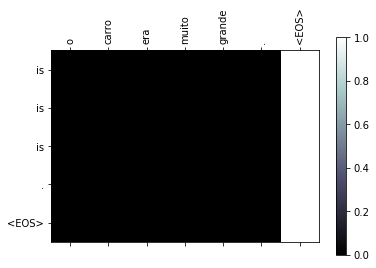

In [27]:
evaluate_and_show_attention("o carro era muito grande .")

input = eu tenho medo de altura .
output = is is is . <EOS>


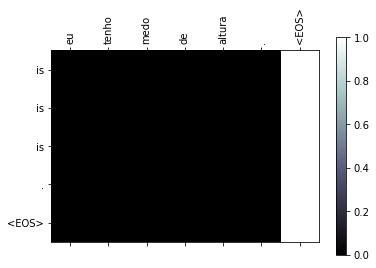

In [28]:
evaluate_and_show_attention("eu tenho medo de altura .")